## Conditioning latent forces on data

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

In [1]:
import torch
import numpy as np
from gpytorch.optim import NGD
from torch.optim import Adam
from torch.nn import Parameter
from matplotlib import pyplot as plt

from alfi.datasets import ToyTranscriptomics, ToyTranscriptomicGenerator
from alfi.configuration import VariationalConfiguration
from alfi.models import TrainMode, generate_multioutput_gp
from alfi.plot import Plotter1d, Colours, tight_kwargs
from alfi.trainers import VariationalTrainer, PreEstimator
from alfi.utilities.data import p53_ground_truth
from alfi.impl.odes import TranscriptionLFM

Let's start by importing our dataset...

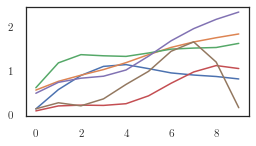

In [2]:
num_genes = 11
num_tfs = 3

dataset = ToyTranscriptomicGenerator(
    num_outputs=num_genes, num_latents=num_tfs, num_times=10, softplus=True, latent_data_present=True)
dataset.generate_single()

ground_truths = p53_ground_truth()
class ConstrainedTrainer(VariationalTrainer):
    def after_epoch(self):
        with torch.no_grad():
            sens = torch.tensor(1.)
            dec = torch.tensor(0.8)
            self.lfm.raw_sensitivity[3] = self.lfm.positivity.inverse_transform(sens)
            self.lfm.raw_decay[3] = self.lfm.positivity.inverse_transform(dec)
        super().after_epoch()


plt.figure(figsize=(4, 2))
for i in range(5):
    plt.plot(dataset[i][1])
plt.plot(dataset.f_observed[0, 0])
t_end = dataset.t_observed[-1]

We use the ordinary differential equation (ODE):

`dy/dt = b + sf(t) - dy`

`f(t) ~ GP(0, k(t, t'))`

Since this is an ODE, we inherit from the `OrdinaryLFM` class.

In [3]:
config = VariationalConfiguration(
    latent_data_present=True,
    num_samples=75,
    initial_conditions=False
)

num_inducing = 20  # (I x m x 1)
inducing_points = torch.linspace(0, t_end, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(0, t_end+2, 80, dtype=torch.float32)
step_size = 5e-1
num_training = dataset.m_observed.shape[-1]
use_natural = True
gp_model = generate_multioutput_gp(num_tfs, inducing_points, gp_kwargs=dict(natural=use_natural))


from alfi.utilities.torch import softplus
class SoftplusTranscriptionLFM(TranscriptionLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        num_latents = gp_model.variational_strategy.num_tasks
        # self.sensitivity = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float32))
        self.weight = Parameter(0.5 * torch.randn(torch.Size([self.num_outputs, num_latents]), dtype=torch.float32))
        self.weight_bias = Parameter(torch.randn(torch.Size([self.num_outputs, 1]), dtype=torch.float32))

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def nonlinearity(self, f):
        return softplus(f)

    def mix(self, f):
        interactions = torch.matmul(self.weight, torch.log(f+1e-100)) + self.weight_bias
        f = torch.sigmoid(interactions) # TF Activation Function (sigmoid)
        return f

lfm = SoftplusTranscriptionLFM(num_genes, gp_model, config, num_training_points=num_training)
plotter = Plotter1d(lfm, dataset.gene_names, style='seaborn')

In [4]:
track_parameters = [
    'raw_basal',
    'raw_decay',
    'raw_sensitivity',
    'gp_model.covar_module.raw_lengthscale',
]
if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.09)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.02)
    optimizers = [variational_optimizer, parameter_optimizer]
    pre_variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    pre_parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.005)
    pre_optimizers = [pre_variational_optimizer, pre_parameter_optimizer]

else:
    optimizers = [Adam(lfm.parameters(), lr=0.05)]
    pre_optimizers = [Adam(lfm.parameters(), lr=0.05)]

trainer = ConstrainedTrainer(lfm, optimizers, dataset, track_parameters=track_parameters)
pre_estimator = PreEstimator(lfm, pre_optimizers, dataset, track_parameters=track_parameters)

### Outputs prior to training:

torch.Size([80, 14])


Text(0.5, 1.0, 'Latent')

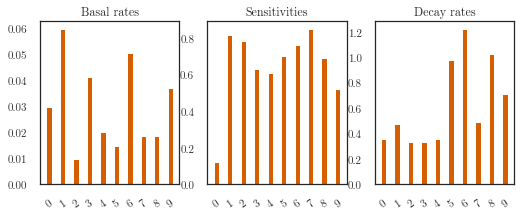

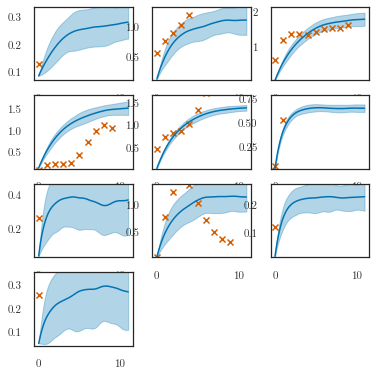

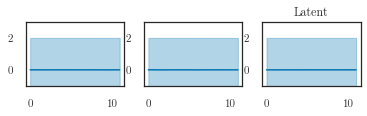

In [5]:
titles = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['raw_basal', 'raw_sensitivity', 'raw_decay']:
    kinetics.append(
        lfm.positivity.transform(trainer.parameter_trace[key][-1].squeeze()).numpy())
kinetics = np.array(kinetics)

plotter.plot_double_bar(kinetics,
                        # ground_truths=p53_ground_truth(),
                        titles=titles)
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)
print(q_m.mean.shape)
plotter.plot_gp(q_m, t_predict, replicate=0,
                t_scatter=dataset.t_observed,
                y_scatter=dataset.m_observed, num_samples=0)
plotter.plot_gp(q_f, t_predict, ylim=(-1, 3))
plt.title('Latent')

In [6]:
lfm.set_mode(TrainMode.GRADIENT_MATCH)
lfm.loss_fn.num_data = 61
pre_estimator.train(50, report_interval=20);

Epoch 001/050 - Loss: 17.05 (17.05 0.00) kernel: [0.69065034 0.6906503  0.6906503 ]
Epoch 021/050 - Loss: 15.68 (15.62 0.07) kernel: [0.7379783 0.731532  0.7385313]
Epoch 041/050 - Loss: 14.94 (14.82 0.12) kernel: [0.79533654 0.78786594 0.7954265 ]


In [7]:
lfm.set_mode(TrainMode.NORMAL)
lfm.loss_fn.num_data = num_training
trainer.train(100, report_interval=10, step_size=step_size);

Epoch 001/100 - Loss: 17.88 (17.03 0.84) kernel: [0.833019   0.82523423 0.80928975]
Epoch 011/100 - Loss: 15.74 (15.16 0.58) kernel: [0.95211995 0.9431144  0.9068506 ]
Epoch 021/100 - Loss: 14.21 (13.63 0.58) kernel: [1.0862824 1.0706663 1.0386918]
Epoch 031/100 - Loss: 12.79 (12.12 0.68) kernel: [1.2351661 1.2056713 1.1891186]
Epoch 041/100 - Loss: 11.40 (10.60 0.81) kernel: [1.388063  1.3462282 1.3110454]
Epoch 051/100 - Loss: 10.08 (9.15 0.93) kernel: [1.5384842 1.4849808 1.4048473]
Epoch 061/100 - Loss: 8.73 (7.67 1.06) kernel: [1.669126  1.6081997 1.4918201]
Epoch 071/100 - Loss: 7.43 (6.26 1.17) kernel: [1.776902  1.6871719 1.5853798]
Epoch 081/100 - Loss: 6.13 (4.85 1.28) kernel: [1.8485826 1.7704512 1.6398464]
Epoch 091/100 - Loss: 4.80 (3.39 1.41) kernel: [1.9187931 1.8648071 1.6571091]


MultitaskMultivariateNormal(loc: torch.Size([240]))

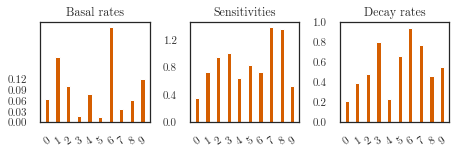

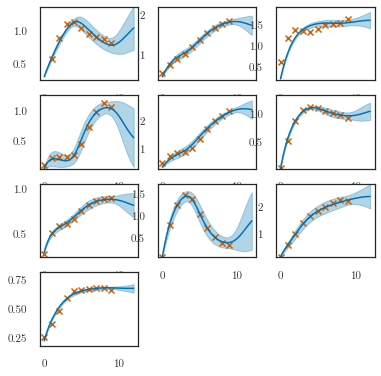

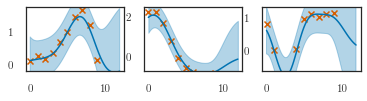

In [8]:
lfm.eval()
t_predict = torch.linspace(0, t_end+3, 80, dtype=torch.float32)

# plotter.plot_losses(trainer, last_x=200)
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)


titles = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['raw_basal', 'raw_sensitivity', 'raw_decay']:
    kinetics.append(
        lfm.positivity.transform(trainer.parameter_trace[key][-1].squeeze()).numpy())
kinetics = np.array(kinetics)
plotter.plot_double_bar(kinetics,
                        titles=titles,
                        figsize=(6.5, 2.3),
                        yticks=[
                            np.linspace(0, 0.12, 5),
                            np.linspace(0, 1.2, 4),
                            np.arange(0, 1.1, 0.2),
                        ])


plt.tight_layout()
# plt.savefig('./kinetics.pdf', **tight_kwargs)

plotter.plot_gp(q_m, t_predict,
                t_scatter=dataset.t_observed, y_scatter=dataset.m_observed)
plotter.plot_gp(q_f, t_predict, t_scatter=dataset.t_observed, y_scatter=dataset.f_observed)